## ProjF5 - Final Model

Use this document as a template to provide the evaluation of your final model. You are welcome to go in as much depth as needed.

Make sure you keep the sections specified in this template, but you are welcome to add more cells with your code or explanation as needed.

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, concatenate, Reshape
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Concatenate, Dropout, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import OneHotEncoder

### 1. Load and Prepare Data

This should illustrate your code for loading the dataset and the split into training, validation and testing. You can add steps like pre-processing if needed.

In [319]:
# Load data from Excel
data = pd.read_excel('/Users/mayur/Desktop/NN/NNDL_Project_F/CSV Datafile.xlsx')

data

,Time,IMAGE,DOLP,Cloud Coverage,Sky
0,10:45:00,/Volumes/Doraemon /BRDF 2021/Data_Skycam/DCIM/...,0.122028,48.967867,Partly Cloudy
1,10:50:00,/Volumes/Doraemon /BRDF 2021/Data_Skycam/DCIM/...,0.110792,49.289283,Partly Cloudy
2,11:50:00,/Volumes/Doraemon /BRDF 2021/Data_Skycam/DCIM/...,0.071582,48.272792,Partly Cloudy
3,12:15:00,/Volumes/Doraemon /BRDF 2021/Data_Skycam/DCIM/...,0.077421,86.216933,Overcast
4,12:40:00,/Volumes/Doraemon /BRDF 2021/Data_Skycam/DCIM/...,0.286818,47.495025,Partly Cloudy
...,...,...,...,...,...
723,0.697917,/Volumes/Doraemon /BRDF 2021/Data_Skycam/DCIM/...,0.172934,31.220458,Partly Cloudy
724,0.739583,/Volumes/Doraemon /BRDF 2021/Data_Skycam/DCIM/...,0.194597,44.797783,Partly Cloudy
725,0.78125,/Volumes/Doraemon /BRDF 2021/Data_Skycam/DCIM/...,0.227131,52.975883,Overcast
726,0.822917,/Volumes/Doraemon /BRDF 2021/Data_Skycam/DCIM/...,0.295154,3.778183,Sunny


In [320]:
data= data[400:700]
condition = (data['DOLP'] > 0.1) & (data['DOLP'] < 0.45)

In [321]:
data = data[condition]

In [322]:
data.describe()

,DOLP,Cloud Coverage
count,275.000000,275.000000
mean,0.189051,42.216510
std,0.061121,34.140816
min,0.100573,0.000000
25%,0.142713,3.112671
50%,0.176468,45.111442
75%,0.222909,76.586858
max,0.429776,96.029000


In [323]:
# Extract image file paths and dolp values
image_paths = data['IMAGE'].tolist()
dolp_values = data['DOLP'].values
cloud_coverage_values = data['Cloud Coverage'].values

In [324]:
# Resize images to 500x500
resized_images = []
for image_path in image_paths:
    img = Image.open(image_path)
    img = img.resize((500, 500))
    img = np.array(img) / 255.0
    resized_images.append(img)

resized_images = np.array(resized_images)

In [325]:
sky_encoder = OneHotEncoder()
sky_encoded = sky_encoder.fit_transform(data['Sky'].values.reshape(-1, 1)).toarray()

sky_encoded_reshaped = sky_encoded.reshape((sky_encoded.shape[0], 1, sky_encoded.shape[1]))

sky_encoded.shape

(275, 3)

### 2. Prepare your Final Model

Here you can have your code to either train (e.g., if you are building it from scratch) your model. These steps may require you to use other packages or python files. You can just call them here. You don't have to include them in your submission. Remember that we will be looking at the saved outputs in the notebooked and we will not run the entire notebook.

In [326]:
# Split the data into training and testing sets
X_train_img, X_test_img, X_train_sky, X_test_sky, y_train, y_test = train_test_split(
    resized_images, sky_encoded_reshaped, dolp_values, test_size=0.3, random_state=42)

In [327]:
# Define the model
cnn_input = Input(shape=(500, 500, 3))
rnn_input = Input(shape=(1, sky_encoded.shape[1]))  # Adjusted input shape for RNN model

#CNN model for image data
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.2)
])


# RNN model for categorical data
rnn_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, sky_encoded.shape[1])),
    LSTM(64),
    Dense(32, activation='relu')
])

cnn_output = cnn_model(cnn_input)
rnn_output = rnn_model(rnn_input)


# combine both models
combined_output = concatenate([cnn_output, rnn_output])


# Add additional dense layers for regression
dense_layer_1 = Dense(64, activation='relu')(combined_output)
dense_layer = Dense(32, activation='relu')(dense_layer_1)
output_layer = Dense(1)(dense_layer_1)

# Combine everything into a single model
final_model = Model(inputs=[cnn_input, rnn_input], outputs=output_layer)

# Compile the model
final_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.losses.mean_absolute_percentage_error])

# Train the model
history = final_model.fit([X_train_img, X_train_sky], y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
5/5 [==============================] - 71s 12s/step - loss: 0.8866 - mean_absolute_percentage_error: 375.9644 - val_loss: 0.0141 - val_mean_absolute_percentage_error: 45.8545
Epoch 2/10
5/5 [==============================] - 59s 12s/step - loss: 0.0109 - mean_absolute_percentage_error: 49.3011 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 37.9319
Epoch 3/10
5/5 [==============================] - 58s 12s/step - loss: 0.0065 - mean_absolute_percentage_error: 35.3986 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 30.0923
Epoch 4/10
5/5 [==============================] - 59s 12s/step - loss: 0.0068 - mean_absolute_percentage_error: 37.7409 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 28.6512
Epoch 5/10
5/5 [==============================] - 58s 12s/step - loss: 0.0059 - mean_absolute_percentage_error: 37.9520 - val_loss: 0.0073 - val_mean_absolute_percentage_error: 30.5688
Epoch 6/10
5/5 [==============================] - 57s 11s/step - loss: 0.0

In [328]:
# Ensure that the shapes of inputs are compatible
print("Shape of X_train_img:", X_train_img.shape)
print("Shape of X_train_sky:", X_train_sky.shape)
print("Shape of y_train:", y_train.shape)

# Validate the concatenation step
print("Shape of combined_input:", combined_input.shape)

# Print model summary to verify the architecture
final_model.summary()

Shape of X_train_img: (192, 500, 500, 3)
Shape of X_train_sky: (192, 1, 3)
Shape of y_train: (192,)
Shape of combined_input: (None, 186, 35)
Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_100 (InputLayer)         [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_101 (InputLayer)         [(None, 1, 3)]       0           []                               
                                                                                                  
 sequential_91 (Sequential)     (None, 32)           3574944     ['input_100[0][0]']              
                                                 

### 3. Model Performance

Make sure to include the following:
- Performance on the training set
- Performance on the test set
- Provide some screenshots of your output (e.g., pictures, text output, or a histogram of predicted values in the case of tabular data). Any visualization of the predictions are welcome.

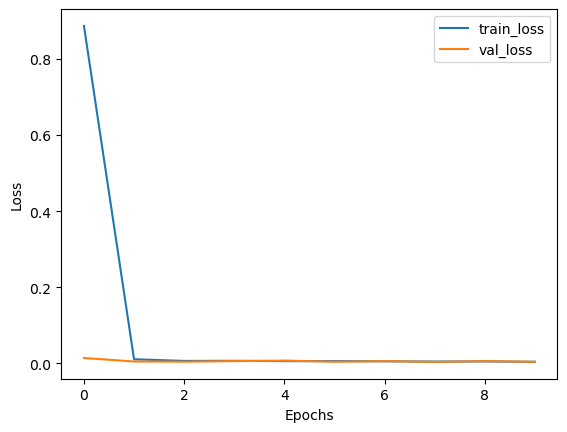

In [329]:
# Plot performance on training and validation set
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [330]:
# Screenshot and visualization of output
y_predicted = final_model.predict([X_test_img,X_test_sky])

3/3 [==============================] - 10s 3s/step


In [331]:
print(y_test.shape)
print(y_predicted.reshape(-1).shape)

(83,)
(83,)


In [332]:
output = pd.DataFrame({"Predicted":y_predicted.reshape(-1),"Actual":y_test})
output[8:13]

,Predicted,Actual
8,0.142892,0.154210
9,0.166120,0.134287
10,0.163802,0.170784
11,0.187689,0.279253
12,0.182603,0.208372


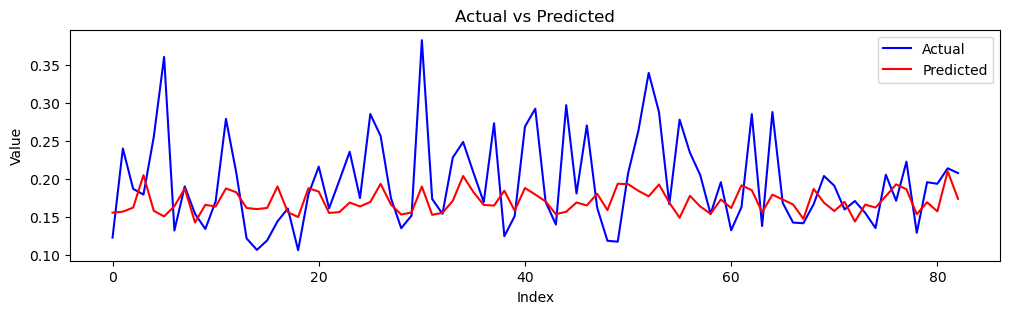

In [333]:
plt.figure(figsize=(12, 3))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_predicted, label='Predicted', color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [334]:
# Performance on test set
loss = final_model.evaluate([X_test_img,X_test_sky], y_test)
print("\nTest Loss (mse):", loss[0])
print("\nMean Absolute Percentage Error:", loss[1])

3/3 [==============================] - 10s 3s/step - loss: 0.0039 - mean_absolute_percentage_error: 20.7650

Test Loss (mse): 0.003930367063730955

Mean Absolute Percentage Error: 20.76504898071289
